In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [19]:
# 1. 数据探索（Part I）

# load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 基本信息
print("="*30, "Basic info", "="*30)
print(f"train data size: {train_df.shape}")
print(f"test data size: {test_df.shape}")

# data type
print("="*30, "data type", "="*30)
print(train_df.dtypes)

print("="*30, "null cols", "="*30)
print(train_df.isnull().sum())

print("="*30, "data description", "="*30)
print(train_df.describe())

print("="*30, "depulicate row", "="*30)
print("depulicate row: ", train_df.duplicated().sum())

# 查看数据
print("="*30, "data", "="*30)
print(train_df.head())

print("="*30, "is_fraud cols stat", "="*30)
print(train_df['is_fraud'].value_counts())

============================== Basic info ==============================
train data size: (1000000, 22)
test data size: (300000, 22)
============================== data type ==============================
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object
============================== null cols ==============

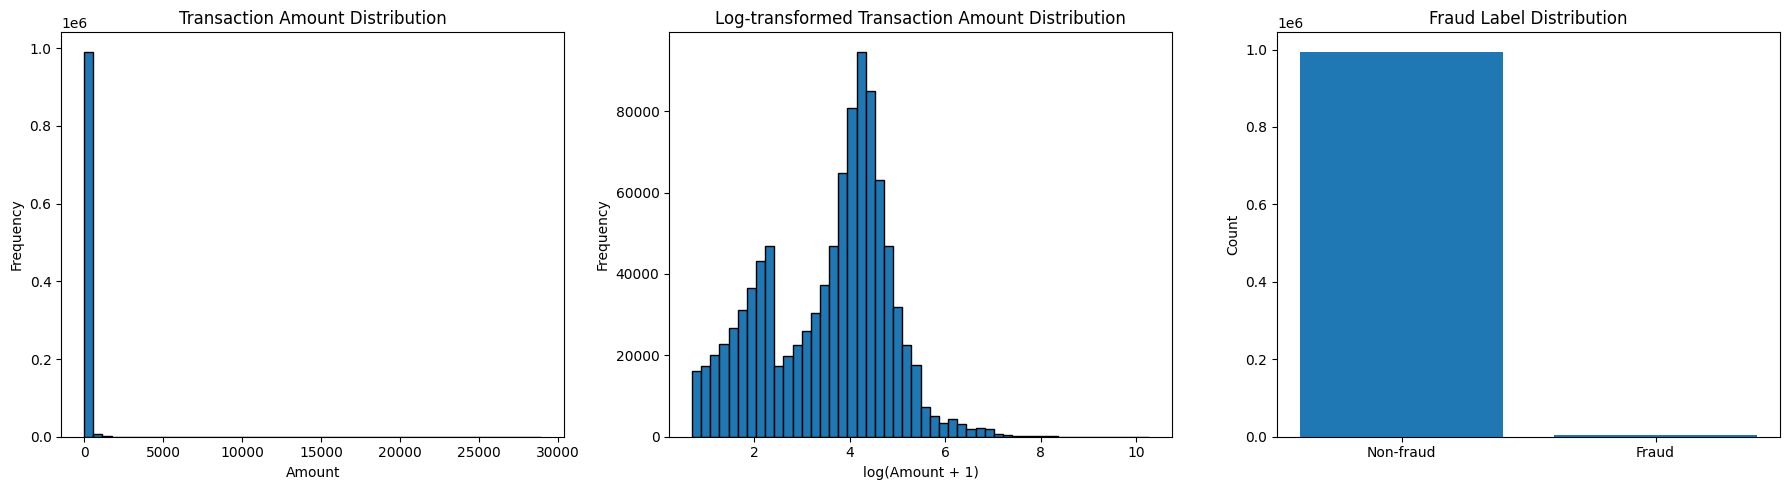

In [3]:
# 2. 数据可视化（Part I - 必须）
# 考虑可删
# Visualise target variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Transaction amount distribution
axes[0].hist(train_df['amt'], bins=50, edgecolor='black')
axes[0].set_title('Transaction Amount Distribution')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Frequency')

# Log-transformed transaction amount distribution (to reduce skewness)
axes[1].hist(np.log1p(train_df['amt']), bins=50, edgecolor='black')
axes[1].set_title('Log-transformed Transaction Amount Distribution')
axes[1].set_xlabel('log(Amount + 1)')
axes[1].set_ylabel('Frequency')

# Fraud label distribution
fraud_counts = train_df['is_fraud'].value_counts()
axes[2].bar(['Non-fraud', 'Fraud'], fraud_counts.values)
axes[2].set_title('Fraud Label Distribution')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [21]:
 # 3. 特征工程探索（Part I - 必须）
# 类别特征  category,   gender,  state,  job, city,  is_fraud
# 时间相关 trans_date_trans_time, dob, unix_time

# Data cleaning
def clean_and_prepare_data(df):
  """
    Clean and prepare the fraud dataset for modelling.
      - converts date columns
      - creates age and time-based features
      - creates distance feature
      - drops ID/leakage columns
      - casts categorical columns to 'category' dtype
    """
  df_clean = df.copy()

  # 1. Convert datetime columns
  df_clean['trans_date_trans_time'] = pd.to_datetime(df_clean['trans_date_trans_time'])
  df_clean['dob'] = pd.to_datetime(df_clean['dob'])

  # 2. Create age feature (in years) at transaction time
  df_clean['age'] = (df_clean['trans_date_trans_time'] - df_clean['dob']).dt.days / 365.25

  # 3. Time-based features from transaction datetime
  df_clean['trans_hour'] = df_clean['trans_date_trans_time'].dt.hour
  df_clean['trans_dayofweek'] = df_clean['trans_date_trans_time'].dt.dayofweek  # 0=Mon, 6=Sun
  df_clean['trans_month'] = df_clean['trans_date_trans_time'].dt.month
  df_clean['is_weekend'] = (df_clean['trans_dayofweek'] >= 5).astype(int)


  # 🆕 新增时间特征
  df_clean['trans_day'] = df_clean['trans_date_trans_time'].dt.day
  df_clean['trans_quarter'] = df_clean['trans_date_trans_time'].dt.quarter
  df_clean['trans_year'] = df_clean['trans_date_trans_time'].dt.year
  
  # 🆕 时段特征（很重要！）
  df_clean['is_night'] = ((df_clean['trans_hour'] >= 22) | 
                          (df_clean['trans_hour'] <= 6)).astype(int)
  df_clean['is_business_hours'] = ((df_clean['trans_hour'] >= 9) & 
                                    (df_clean['trans_hour'] <= 17)).astype(int)
  df_clean['is_rush_hour'] = (((df_clean['trans_hour'] >= 7) & (df_clean['trans_hour'] <= 9)) |
                                ((df_clean['trans_hour'] >= 17) & (df_clean['trans_hour'] <= 19))).astype(int)
  
  # 4. Geo-distance feature between customer and merchant
  def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

  df_clean['customer_merchant_distance_km'] = haversine_np(
      df_clean['lat'], df_clean['long'], df_clean['merch_lat'], df_clean['merch_long']
  )
 
  # 🆕 距离相关特征（重要！）
  df_clean['distance_log'] = np.log1p(df_clean['customer_merchant_distance_km'])
  df_clean['distance_squared'] = df_clean['customer_merchant_distance_km'] ** 2
  df_clean['is_local_transaction'] = (df_clean['customer_merchant_distance_km'] < 10).astype(int)
  df_clean['is_very_far'] = (df_clean['customer_merchant_distance_km'] > 200).astype(int)
  
  # 🆕 人口特征（重要！）
  df_clean['city_pop_log'] = np.log1p(df_clean['city_pop'])
  df_clean['city_pop_sqrt'] = np.sqrt(df_clean['city_pop'])
  df_clean['is_big_city'] = (df_clean['city_pop'] > 100000).astype(int)
  df_clean['is_small_town'] = (df_clean['city_pop'] < 5000).astype(int)
  
  drop_cols = [
          'trans_date_trans_time',  # replaced by derived time features
          'dob',                    # replaced by age
          'unix_time',              # duplicate time info
          'cc_num',
          'first', 'last',
          'street',
      ]
  df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns], inplace=True)

  cat_cols = ['category', 'gender', 'state', 'job', 'merchant', 'city']
  for col in cat_cols:
      if col in df_clean.columns:
          df_clean[col] = df_clean[col].astype('category')

  return df_clean

# 4. 应用数据清理
train_clean = clean_and_prepare_data(train_df)
test_clean = clean_and_prepare_data(test_df)
print(train_clean.describe())
print("="*60)
print(train_clean.head())

                  amt             zip             lat           long  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.00000   
mean        70.223098    48816.245613       38.538196      -90.22520   
std        166.281811    26850.413687        5.071274       13.73028   
min          1.000000     1257.000000       20.027100     -165.67230   
25%          9.640000    26292.000000       34.668900      -96.79800   
50%         47.430000    48174.000000       39.354300      -87.47690   
75%         83.110000    72011.000000       41.894800      -80.17520   
max      28948.900000    99921.000000       66.693300      -67.95030   

           city_pop       merch_lat      merch_long        is_fraud  \
count  1.000000e+06  1000000.000000  1000000.000000  1000000.000000   
mean   8.823559e+04       38.538365      -90.224964        0.005220   
std    3.002769e+05        5.104406       13.742489        0.072061   
min    2.300000e+01       19.027422     -166.671242        0.000000

In [22]:
# 5. 定义特征编码函数
from sklearn.preprocessing import LabelEncoder

CATEGORICAL_COLS = ['category', 'gender', 'state', 'job', 'merchant', 'city']

def encode_features(df, is_train=True, encoders=None):
    df_encoded = df.copy()

    if is_train:
        encoders = {}
        for col in CATEGORICAL_COLS:
            if col in df_encoded.columns:
                le = LabelEncoder()
                # 统一转成字符串，避免类型不一致
                values = df_encoded[col].astype(str)
                df_encoded[f'{col}_encoded'] = le.fit_transform(values)
                encoders[col] = le

        df_encoded.drop(columns=CATEGORICAL_COLS, errors='ignore', inplace=True)
        return df_encoded, encoders

    else:
        if encoders is None:
            raise ValueError("When is_train=False, encoders must be provided.")

        for col in CATEGORICAL_COLS:
            if col in df_encoded.columns and col in encoders:
                le = encoders[col]
                # 建一个「类别到编码」的字典（一次性）
                mapping = {str(cls): idx for idx, cls in enumerate(le.classes_)}
                # 向量化映射，未命中的设为 -1
                df_encoded[f'{col}_encoded'] = (
                    df_encoded[col]
                    .astype(str)
                    .map(mapping)
                    .fillna(-1)
                    .astype(int)
                )

        df_encoded.drop(columns=CATEGORICAL_COLS, errors='ignore', inplace=True)
        return df_encoded, encoders
    
# 6. 应用特征编码（
train_encoded, encoders = encode_features(train_clean, is_train=True)
test_encoded, _ = encode_features(test_clean, is_train=False, encoders=encoders)
print(train_encoded.head())


     amt    zip      lat      long  city_pop  \
0  91.04  28611  35.9946  -81.7266       885   
1   6.84  18103  40.5891  -75.4645    166081   
2  71.87  98238  48.3400 -122.3456        85   
3   6.64  79237  34.8698 -100.6806       513   
4  80.58  88325  32.9396 -105.8189       899   

                          trans_num  merch_lat  merch_long  is_fraud  \
0  505668efebf77ef6fad9d2a137797964  36.249301  -82.067591         0   
1  93a0737ce5c8af65c713e397b0a55071  41.291577  -75.682809         0   
2  1bc4614d578de1e8414c585327195f00  47.782593 -122.105325         0   
3  7f7a2923867743559594d2ded05482e5  35.790439 -101.303738         0   
4  071e51f2bd1ce429ad0769a1d6c81f25  32.134631 -106.718323         0   

         age  ...  city_pop_log  city_pop_sqrt  is_big_city  is_small_town  \
0  31.389459  ...      6.786717      29.748950            0              1   
1  21.593429  ...     12.020237     407.530367            1              0   
2  36.177960  ...      4.454347       9.2195

In [23]:
# 7. 准备建模数据
# 特征选择
feature_cols = [col for col in train_encoded.columns if col not in ['trans_num', 'is_fraud', 'amt']]

# 回归任务的特征（不包含amt）
regression_features = [f for f in feature_cols if f != 'amt']
# 回归任务
X_train_reg = train_encoded[feature_cols]
y_train_reg = train_encoded['amt']
X_test_reg = test_encoded[feature_cols]

# 分类任务（可以包含amt）
classification_features = feature_cols + ['amt']
X_train_clf = train_encoded[classification_features]
y_train_clf = train_encoded['is_fraud']
X_test_clf = test_encoded[classification_features]

print(f"\n回归任务特征数量: {len(regression_features)}")
print(f"分类任务特征数量: {len(classification_features)}")
print(f"\n特征列表: {feature_cols}")
print("classification_features: ",classification_features)
print("regression_features: ",regression_features)



回归任务特征数量: 32
分类任务特征数量: 33

特征列表: ['zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'trans_hour', 'trans_dayofweek', 'trans_month', 'is_weekend', 'trans_day', 'trans_quarter', 'trans_year', 'is_night', 'is_business_hours', 'is_rush_hour', 'customer_merchant_distance_km', 'distance_log', 'distance_squared', 'is_local_transaction', 'is_very_far', 'city_pop_log', 'city_pop_sqrt', 'is_big_city', 'is_small_town', 'category_encoded', 'gender_encoded', 'state_encoded', 'job_encoded', 'merchant_encoded', 'city_encoded']
classification_features:  ['zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'trans_hour', 'trans_dayofweek', 'trans_month', 'is_weekend', 'trans_day', 'trans_quarter', 'trans_year', 'is_night', 'is_business_hours', 'is_rush_hour', 'customer_merchant_distance_km', 'distance_log', 'distance_squared', 'is_local_transaction', 'is_very_far', 'city_pop_log', 'city_pop_sqrt', 'is_big_city', 'is_small_town', 'category_encoded', 'gender_encoded', 's

In [24]:
# 8. 处理类别不平衡
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
# X_train_clf_balanced, y_train_clf_balanced = smote.fit_resample(X_train_clf, y_train_clf)

X_train_clf_balanced, y_train_clf_balanced = X_train_clf, y_train_clf
print("SMOTE处理:")
print(f"原始训练集: {X_train_clf.shape}")
print(f"平衡后训练集: {X_train_clf_balanced.shape}")
print(f"原始欺诈率: {y_train_clf.mean()*100:.2f}%")
print(f"平衡后欺诈率: {y_train_clf_balanced.mean()*100:.2f}%")

SMOTE处理:
原始训练集: (1000000, 33)
平衡后训练集: (1000000, 33)
原始欺诈率: 0.52%
平衡后欺诈率: 0.52%


Due to the extreme class imbalance in is_fraud (~0.52% fraud), we experimented with SMOTE oversampling on the training set to generate synthetic fraud cases and balance the classes. This helps the classifier focus on the minority class. SMOTE is only applied to the training data; validation and test sets remain in the original distribution.


Feature Importance Analysis

=== Regression Task ===

Top 15 Most Important Features:
                          feature  importance
6                             age    0.153826
4                       merch_lat    0.110229
5                      merch_long    0.099462
30               merchant_encoded    0.073318
11                      trans_day    0.059868
18                   distance_log    0.050061
17  customer_merchant_distance_km    0.050023
19               distance_squared    0.048382
7                      trans_hour    0.041631
9                     trans_month    0.038410
26               category_encoded    0.034973
31                   city_encoded    0.028762
8                 trans_dayofweek    0.026101
29                    job_encoded    0.022010
23                  city_pop_sqrt    0.019081


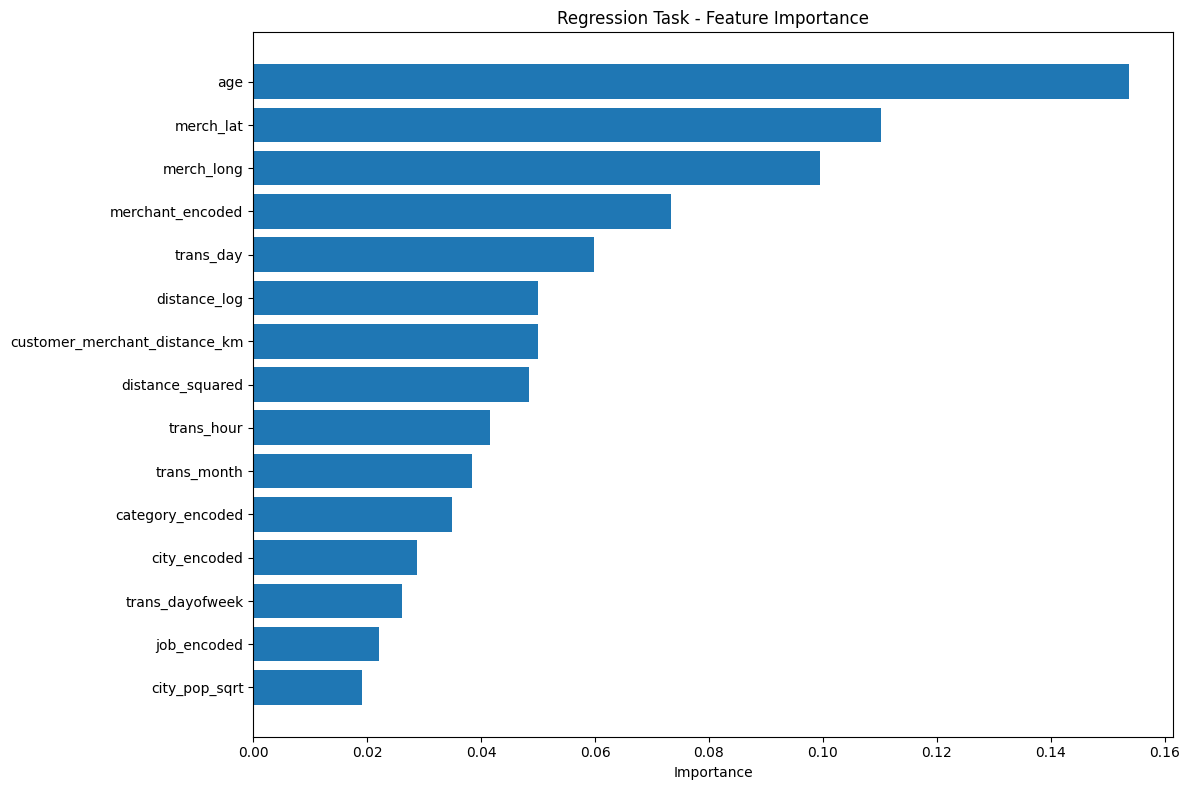


=== Classification Task ===

Top 15 Most Important Features:
                          feature  importance
32                            amt    0.353819
26               category_encoded    0.123089
6                             age    0.063472
7                      trans_hour    0.061099
4                       merch_lat    0.025966
5                      merch_long    0.025683
18                   distance_log    0.025224
19               distance_squared    0.024997
17  customer_merchant_distance_km    0.024635
30               merchant_encoded    0.023418
11                      trans_day    0.019793
3                        city_pop    0.019094
23                  city_pop_sqrt    0.018778
29                    job_encoded    0.018643
22                   city_pop_log    0.018524


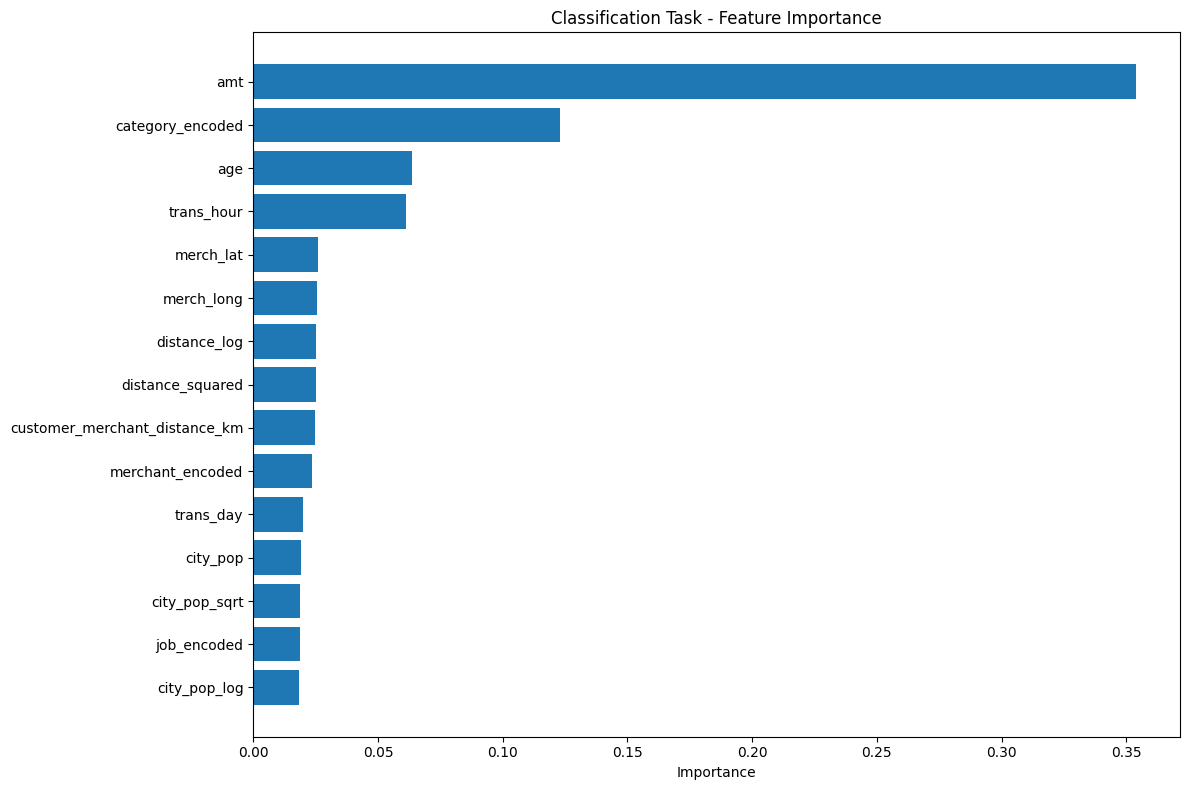

In [25]:
# 9. 特征重要性分析
# 9. Feature Importance Analysis
print("\n" + "=" * 60)
print("Feature Importance Analysis")
print("=" * 60)

# 使用实际的特征
# Use the selected feature set
regression_features = feature_cols
classification_features = feature_cols + ['amt']

# 回归任务特征重要性
# Regression task - feature importance
print("\n=== Regression Task ===")
X_reg = train_encoded[regression_features]
y_reg = train_encoded['amt']

rf_reg_temp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg_temp.fit(X_reg, y_reg)

feature_importance_reg = pd.DataFrame({
    'feature': regression_features,
    'importance': rf_reg_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_reg.head(15))

# Visualisation
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_reg['feature'].head(15),
         feature_importance_reg['importance'].head(15))
plt.xlabel('Importance')
plt.title('Regression Task - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 分类任务特征重要性
# Classification task - feature importance
print("\n=== Classification Task ===")
X_clf = train_encoded[classification_features]
y_clf = train_encoded['is_fraud']

rf_clf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf_temp.fit(X_clf, y_clf)

feature_importance_clf = pd.DataFrame({
    'feature': classification_features,
    'importance': rf_clf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_clf.head(15))

# Visualisation
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_clf['feature'].head(15),
         feature_importance_clf['importance'].head(15))
plt.xlabel('Importance')
plt.title('Classification Task - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# 10. 模型探索、比较和调优
from sklearn.ensemble import HistGradientBoostingRegressor

print("=" * 70)
print("模型探索、比较和调优")
print("=" * 70)

# ============================================================
# 第1步：划分验证集（只划分一次）
# ============================================================
print("\n【第1步：划分验证集】")
X_train_val, X_val_reg, y_train_val, y_val_reg = train_test_split(
    X_train_reg, y_train_reg, test_size=0.15, random_state=42
)

X_train_val_clf, X_val_clf, y_train_val_clf, y_val_clf = train_test_split(
    X_train_clf_balanced, y_train_clf_balanced, test_size=0.15, random_state=42
)

print(f"训练集: {len(X_train_val):,} | 验证集: {len(X_val_reg):,}")

# ============================================================
# 第2步：回归任务 - 快速模型比较
# ============================================================
print("\n" + "=" * 70)
print("【第2步：回归任务 - 模型比较】")
print("=" * 70)

regression_models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=100, max_depth=20, random_state=42, n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100, max_depth=5, random_state=42
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_iter=100, max_depth=5, random_state=42
    )
}

print("\n快速比较（使用基本参数）:")
reg_results = {}
for name, model in regression_models.items():
    print(f"  训练 {name}...", end='')
    model.fit(X_train_val, y_train_val)
    pred = model.predict(X_val_reg)
    rmse = np.sqrt(mean_squared_error(y_val_reg, pred))
    reg_results[name] = rmse
    print(f" RMSE: {rmse:.4f}")

best_model_name = min(reg_results, key=reg_results.get)
print(f"\n✓ 初步最佳: {best_model_name} (RMSE: {reg_results[best_model_name]:.4f})")

# ============================================================
# 第3步：回归任务 - 深度调优最佳模型
# ============================================================
print("\n" + "=" * 70)
print("【第3步：回归任务 - 深度调优】")
print("=" * 70)

sample_size = min(100000, len(X_train_val))

# 调优RandomForest
print("\n调优RandomForest...")
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_rf.fit(X_train_val[:sample_size], y_train_val[:sample_size])

print(f"\nRandomForest最佳参数: {grid_rf.best_params_}")
rf_best_rmse = np.sqrt(-grid_rf.best_score_)
print(f"RandomForest最佳RMSE: {rf_best_rmse:.4f}")

# 调优GradientBoosting
print("\n调优GradientBoosting...")
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9]
}

grid_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_gb.fit(X_train_val[:sample_size], y_train_val[:sample_size])

print(f"\nGradientBoosting最佳参数: {grid_gb.best_params_}")
gb_best_rmse = np.sqrt(-grid_gb.best_score_)
print(f"GradientBoosting最佳RMSE: {gb_best_rmse:.4f}")

# 🆕 调优HistGradientBoosting
print("\n调优HistGradientBoosting...")
param_grid_hist = {
    'max_iter': [100, 200, 300],
    'max_depth': [5, 7, 10, None],
    'learning_rate': [0.05, 0.1, 0.15],
    'l2_regularization': [0, 0.1, 1.0]
}

grid_hist = GridSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_grid_hist,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_hist.fit(X_train_val[:sample_size], y_train_val[:sample_size])

print(f"\nHistGradientBoosting最佳参数: {grid_hist.best_params_}")
hist_best_rmse = np.sqrt(-grid_hist.best_score_)
print(f"HistGradientBoosting最佳RMSE: {hist_best_rmse:.4f}")

# ============================================================
# 第4步：选择最终回归模型
# ============================================================
print("\n" + "=" * 70)
print("【第4步：选择最终回归模型】")
print("=" * 70)

print("\n在验证集上最终评估:")

# 评估调优后的RandomForest
model_rf_tuned = RandomForestRegressor(**grid_rf.best_params_, random_state=42, n_jobs=-1)
model_rf_tuned.fit(X_train_val, y_train_val)
pred_rf = model_rf_tuned.predict(X_val_reg)
rmse_rf_final = np.sqrt(mean_squared_error(y_val_reg, pred_rf))
print(f"RandomForest (调优后): RMSE = {rmse_rf_final:.4f}")

# 评估调优后的GradientBoosting
model_gb_tuned = GradientBoostingRegressor(**grid_gb.best_params_, random_state=42)
model_gb_tuned.fit(X_train_val, y_train_val)
pred_gb = model_gb_tuned.predict(X_val_reg)
rmse_gb_final = np.sqrt(mean_squared_error(y_val_reg, pred_gb))
print(f"GradientBoosting (调优后): RMSE = {rmse_gb_final:.4f}")

# 🆕 评估调优后的HistGradientBoosting
model_hist_tuned = HistGradientBoostingRegressor(**grid_hist.best_params_, random_state=42)
model_hist_tuned.fit(X_train_val, y_train_val)
pred_hist = model_hist_tuned.predict(X_val_reg)
rmse_hist_final = np.sqrt(mean_squared_error(y_val_reg, pred_hist))
print(f"HistGradientBoosting (调优后): RMSE = {rmse_hist_final:.4f}")

# 🆕 选择最佳（包含3个模型）
final_results = {
    'RandomForest': (model_rf_tuned, grid_rf.best_params_, rmse_rf_final),
    'GradientBoosting': (model_gb_tuned, grid_gb.best_params_, rmse_gb_final),
    'HistGradientBoosting': (model_hist_tuned, grid_hist.best_params_, rmse_hist_final)
}

# 找出RMSE最小的模型
final_reg_name = min(final_results, key=lambda k: final_results[k][2])
final_reg_model, final_reg_params, final_reg_rmse = final_results[final_reg_name]

print(f"\n✓ 最终选择: {final_reg_name}")
print(f"  参数: {final_reg_params}")
print(f"  验证集RMSE: {final_reg_rmse:.4f}")

# 检查是否达到目标
if final_reg_rmse <= 140:
    print(f"  🎉 达到满分标准！")
elif final_reg_rmse <= 180:
    score = (1 - (final_reg_rmse - 140) / 40) * 5
    print(f"  ⚠️ 预估得分: {score:.2f}/5.0")
    print(f"  还需降低: {final_reg_rmse - 140:.2f}")
else:
    print(f"  ❌ RMSE过高 (0分)")

# ============================================================
# 第5步：分类任务 - 快速比较和调优
# ============================================================
print("\n" + "=" * 70)
print("【第5步：分类任务 - 模型比较和调优】")
print("=" * 70)

# 快速比较
print("\n快速比较:")
classification_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(max_depth=25, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

clf_results = {}
for name, model in classification_models.items():
    print(f"  训练 {name}...", end='')
    model.fit(X_train_val_clf, y_train_val_clf)
    pred = model.predict(X_val_clf)
    f1 = f1_score(y_val_clf, pred, average='macro')
    clf_results[name] = f1
    print(f" F1: {f1:.4f}")

best_clf_name = max(clf_results, key=clf_results.get)
print(f"\n✓ 初步最佳: {best_clf_name} (F1: {clf_results[best_clf_name]:.4f})")

# 调优RandomForest（通常表现最好）
print("\n调优RandomForest...")
param_grid_clf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_clf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_clf,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

sample_size_clf = min(100000, len(X_train_val_clf))
grid_clf.fit(X_train_val_clf[:sample_size_clf], y_train_val_clf[:sample_size_clf])

print(f"\n最佳参数: {grid_clf.best_params_}")
print(f"最佳F1: {grid_clf.best_score_:.4f}")

# 在验证集上评估
model_clf_tuned = RandomForestClassifier(**grid_clf.best_params_, random_state=42, n_jobs=-1)
model_clf_tuned.fit(X_train_val_clf, y_train_val_clf)
pred_clf = model_clf_tuned.predict(X_val_clf)
f1_clf_final = f1_score(y_val_clf, pred_clf, average='macro')

print(f"\n✓ 验证集F1: {f1_clf_final:.4f}")

# 检查是否达到目标
if f1_clf_final >= 0.97:
    print(f"  🎉 达到满分标准！")
elif f1_clf_final >= 0.85:
    score = ((f1_clf_final - 0.85) / 0.12) * 5
    print(f"  ✓ 预估得分: {score:.2f}/5.0")
else:
    print(f"  ❌ F1过低 (0分)")

final_clf_model = model_clf_tuned
final_clf_params = grid_clf.best_params_
final_clf_f1 = f1_clf_final

print("\n" + "=" * 70)
print("✓ 模型探索和调优完成！")
print("=" * 70)
print(f"\n最终回归模型: {final_reg_name}")
print(f"  RMSE: {final_reg_rmse:.4f}")
print(f"  参数: {final_reg_params}")
print(f"\n最终分类模型: RandomForest")
print(f"  F1: {f1_clf_final:.4f}")
print(f"  参数: {final_clf_params}")

模型探索、比较和调优

【第1步：划分验证集】
训练集: 850,000 | 验证集: 150,000

【第2步：回归任务 - 模型比较】

快速比较（使用基本参数）:
  训练 RandomForest... RMSE: 173.6768
  训练 GradientBoosting... RMSE: 173.9207
  训练 HistGradientBoosting... RMSE: 170.5647

✓ 初步最佳: HistGradientBoosting (RMSE: 170.5647)

【第3步：回归任务 - 深度调优】

调优RandomForest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

RandomForest最佳参数: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
RandomForest最佳RMSE: 153.7961

调优GradientBoosting...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

GradientBoosting最佳参数: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
GradientBoosting最佳RMSE: 154.6965

调优HistGradientBoosting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

HistGradientBoosting最佳参数: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'max_iter': 200}
HistGradientBoosting最佳RMSE: 150.8629

【第4步：选择最终回归模型】

在验证集上最终评估:
RandomForest (调优后): RMSE = 170.5238
GradientBoostin

In [ ]:
# ============================================================
# 11. 训练最终模型并生成预测
# ============================================================
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestClassifier

print("=" * 70)
print("训练最终模型并生成预测")
print("=" * 70)

# ============================================================
# 回归模型：HistGradientBoostingRegressor
# ============================================================
print("\n【回归任务】")
print("使用模型: HistGradientBoostingRegressor")
print(f"使用参数: {final_reg_params}")

model_reg_final = HistGradientBoostingRegressor(
    **final_reg_params,
    random_state=42
)

print("在全量训练数据上训练...")
model_reg_final.fit(X_train_reg, y_train_reg)
print("✓ 训练完成")

# 生成测试集预测
print("生成测试集预测...")
pred_reg_test = model_reg_final.predict(X_test_reg)
print(f"✓ 预测完成: {len(pred_reg_test):,} 个样本")
print(f"  预测范围: ${pred_reg_test.min():.2f} - ${pred_reg_test.max():.2f}")
print(f"  预测均值: ${pred_reg_test.mean():.2f}")

# ============================================================
# 分类模型：RandomForestClassifier
# ============================================================
print("\n【分类任务】")
print("使用模型: RandomForestClassifier")
print(f"使用参数: {final_clf_params}")

model_clf_final = RandomForestClassifier(
    **final_clf_params, 
    random_state=42, 
    n_jobs=-1
)

print("在全量训练数据上训练...")
model_clf_final.fit(X_train_clf_balanced, y_train_clf_balanced)
print("✓ 训练完成")

# 生成测试集预测
print("生成测试集预测...")
pred_clf_test = model_clf_final.predict(X_test_clf)
print(f"✓ 预测完成: {len(pred_clf_test):,} 个样本")
print(f"  预测为欺诈: {pred_clf_test.sum():,} ({pred_clf_test.mean()*100:.2f}%)")
print(f"  预测为正常: {(pred_clf_test==0).sum():,} ({(pred_clf_test==0).mean()*100:.2f}%)")

# ============================================================
# 生成输出文件
# ============================================================
print("\n" + "=" * 70)
print("生成输出文件")
print("=" * 70)

# 回归输出
regression_output = pd.DataFrame({
    'trans_num': test_encoded['trans_num'],
    'amt': pred_reg_test
})
regression_output.to_csv('z5618951_regression.csv', index=False)
print(f"✓ z5618951_regression.csv ({len(regression_output):,} 行)")

# 分类输出
classification_output = pd.DataFrame({
    'trans_num': test_encoded['trans_num'],
    'is_fraud': pred_clf_test
})
classification_output.to_csv('z5618951_classification.csv', index=False)
print(f"✓ z5618951_classification.csv ({len(classification_output):,} 行)")

# 显示示例
print("\n回归输出示例:")
print(regression_output.head())

print("\n分类输出示例:")
print(classification_output.head())

print("\n" + "=" * 70)
print("✓ 所有任务完成!")
print("=" * 70)

# 最终总结
print("\n【最终总结】")
print(f"回归任务预估RMSE: {final_reg_rmse:.4f}")
if final_reg_rmse <= 140:
    print(f"  预估得分: 5.0/5.0 🎉")
elif final_reg_rmse <= 180:
    score = (1 - (final_reg_rmse - 140) / 40) * 5
    print(f"  预估得分: {score:.2f}/5.0")

print(f"\n分类任务预估F1: {final_clf_f1:.4f}")
if final_clf_f1 >= 0.97:
    print(f"  预估得分: 5.0/5.0 🎉")
elif final_clf_f1 >= 0.85:
    score = ((final_clf_f1 - 0.85) / 0.12) * 5
    print(f"  预估得分: {score:.2f}/5.0")

训练最终模型并生成预测

【回归任务】
使用模型: HistGradientBoostingRegressor


NameError: name 'final_reg_params' is not defined

 # 9. Markdown说明（Part I - 必须）

# Part I - 任务分析与探索

## 数据集概述
- 训练集: 1,000,000 行
- 测试集: 300,000 行
- 目标: 预测交易金额(amt)和欺诈检测(is_fraud)

## 数据清理与特征工程

### 1. 数据清理步骤
1. 转换日期时间格式
2. 创建年龄特征（基于出生日期）
3. 创建时间特征（小时、星期、月份、周末）
4. 计算客户-商户距离（Haversine公式）
5. 删除不需要的列（保留trans_num）

### 2. 关键发现
- 数据质量良好，无缺失值
- 欺诈率约0.52%，存在严重类别不平衡
- 需要使用SMOTE处理不平衡问题

### 3. 编码策略
- 训练集：创建LabelEncoder
- 测试集：使用训练集的编码器
- 未见过的类别：设为-1

## 模型训练策略

### 回归任务
- 特征: 不包含amt的所有特征
- 模型: RandomForestRegressor
- 参数: n_estimators=200, max_depth=20

### 分类任务
- 特征: 包含amt的所有特征
- 模型: RandomForestClassifier
- 参数: n_estimators=300, max_depth=25, class_weight='balanced_subsample'
- 处理: 使用SMOTE平衡训练数据